In [1]:
import time
import glob
import pathlib
from collections import Counter

import mne
import pywt
from autoreject import AutoReject

from sklearn.ensemble import RandomForestClassifier
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mne.viz.set_browser_backend('matplotlib')

Using matplotlib as 2D backend.


## Data Loading

In [3]:
raw = mne.io.read_raw_edf("/home/fahmi/research/eegautism/data/edf/autism/Bader_Autism_24_11_2011S001R09.edf")
raw.rename_channels({"FP2": "Fp2"}, verbose=False)
raw.set_montage("standard_1020", verbose=False)
raw

Extracting EDF parameters from /home/fahmi/research/eegautism/data/edf/autism/Bader_Autism_24_11_2011S001R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<RawEDF | Bader_Autism_24_11_2011S001R09.edf, 16 x 212144 (828.6 s), ~24 kB, data not loaded>

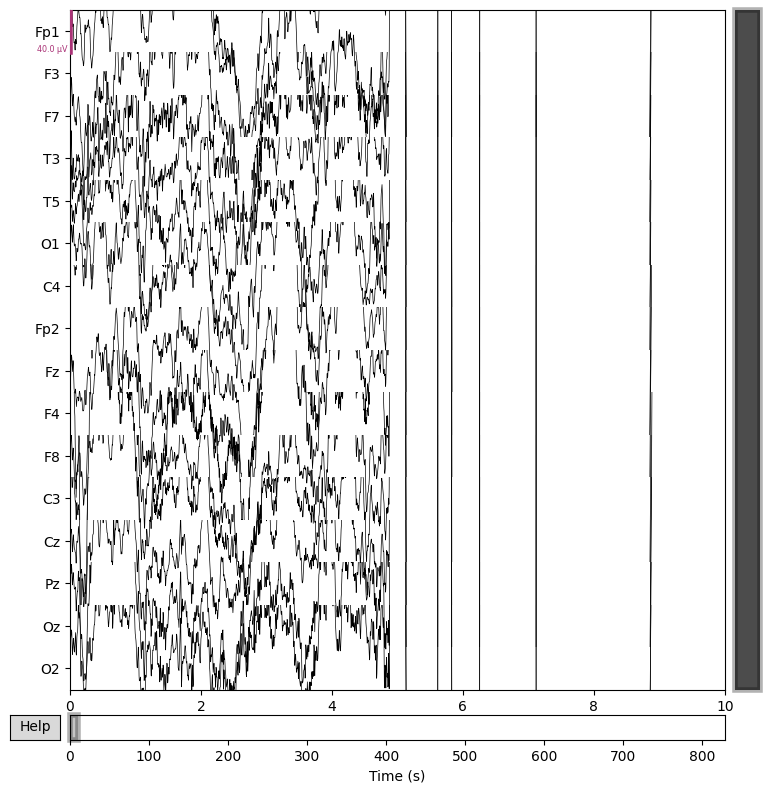

In [4]:
raw.plot(duration=10)
plt.show()

Effective window size : 7.999 (s)
Plotting power spectral density (dB=True).


/home/fahmi/research/eegautism/.venv/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


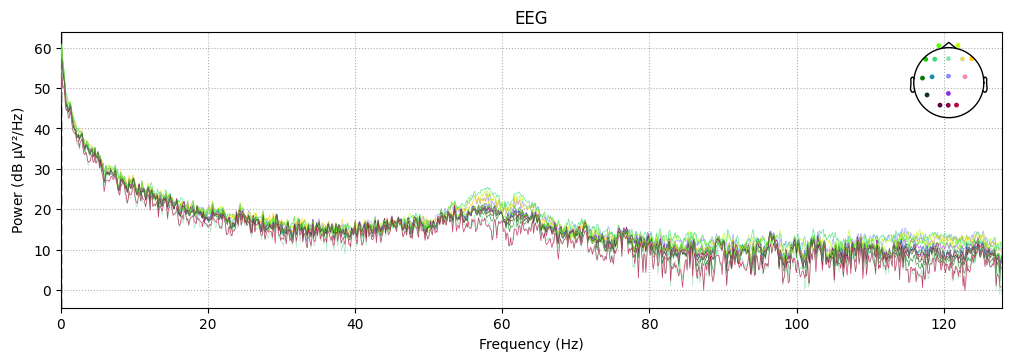

In [11]:
raw.compute_psd(fmax=128).plot(picks="data", exclude="bads", amplitude=False)
plt.show()

## Filters

In [15]:
raw_filt = raw.copy().load_data().filter(l_freq=0.1, h_freq=60)
raw_filt

Reading 0 ... 212143  =      0.000 ...   828.631 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 8449 samples (33.002 s)



<RawEDF | Bader_Autism_24_11_2011S001R09.edf, 16 x 212144 (828.6 s), ~25.9 MB, data loaded>

Effective window size : 7.999 (s)
Plotting power spectral density (dB=True).


/home/fahmi/research/eegautism/.venv/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


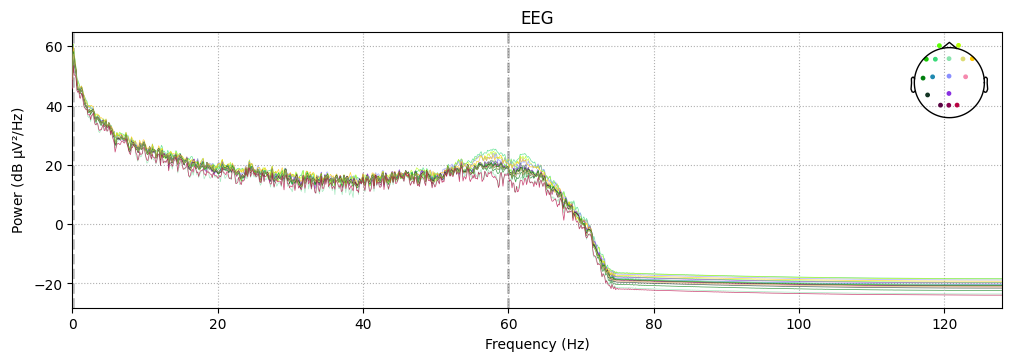

In [16]:
raw_filt.compute_psd(fmax=128).plot(picks="data", exclude="bads", amplitude=False)
plt.show()

In [17]:
raw_notch = raw_filt.copy().load_data().notch_filter(freqs=(60))
raw_notch

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1691 samples (6.605 s)



<RawEDF | Bader_Autism_24_11_2011S001R09.edf, 16 x 212144 (828.6 s), ~25.9 MB, data loaded>

Effective window size : 7.999 (s)


Plotting power spectral density (dB=True).


/home/fahmi/research/eegautism/.venv/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


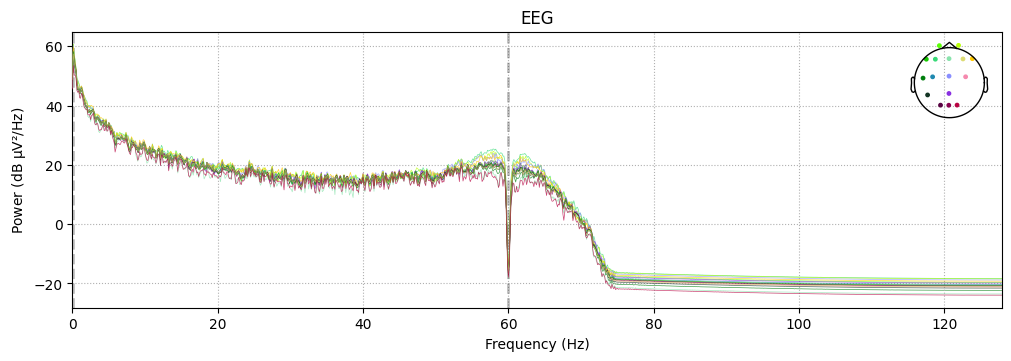

In [19]:
raw_notch.compute_psd(fmax=128).plot(picks="data", exclude="bads", amplitude=False)
plt.show()

## Ocular Artifact Removal

In [34]:
raw_ica = raw_notch.copy().load_data()
raw_ica

<RawEDF | Bader_Autism_24_11_2011S001R09.edf, 16 x 212144 (828.6 s), ~25.9 MB, data loaded>

In [35]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=16, random_state=97, max_iter=800)
ica.fit(raw_ica)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 16 components
Fitting ICA took 5.2s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,60 iterations on raw data (212144 samples)
ICA components,16
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


In [36]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw, ch_name="Fp1")
eog_epochs

Using EOG channel: Fp1
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2561 samples (10.003 s)

Now detecting blinks and generating corresponding events
Found 116 significant peaks
Number of EOG events detected: 116
Not setting metadata
116 matching events found
No baseline correction applied
Loading data for 116 events and 257 original time points ...
0 bad epochs dropped


<Epochs | 116 events (all good), -0.5 – 0.5 s (baseline off), ~3.7 MB, data loaded,
 '998': 116>

Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


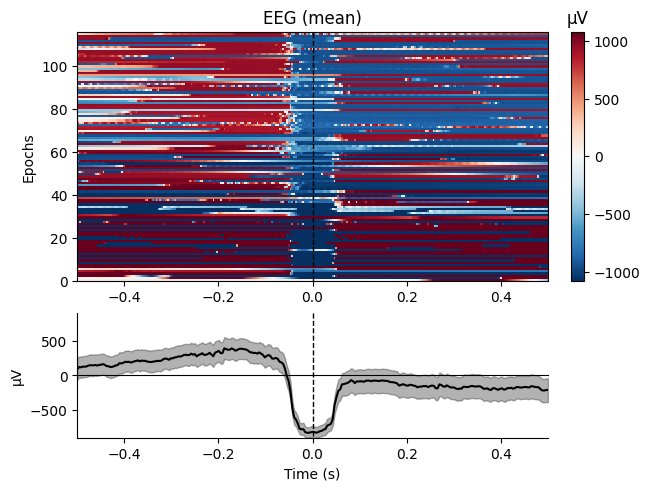

In [37]:
eog_epochs.plot_image(combine="mean")
plt.show()

No projector specified for this dataset. Please consider the method self.add_proj.


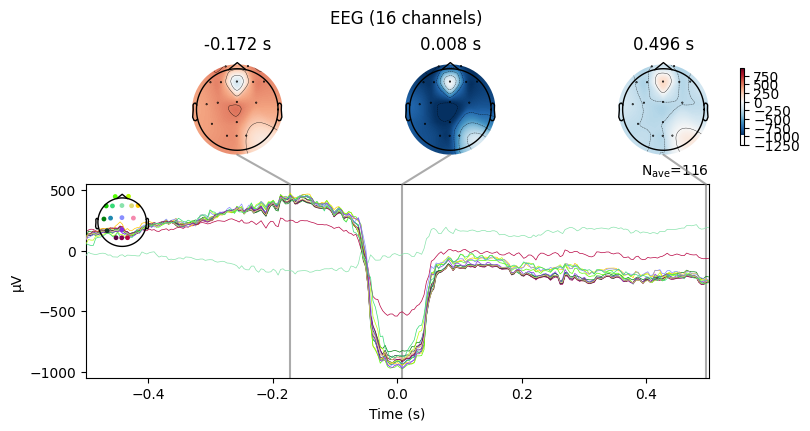

In [38]:
eog_epochs.average().plot_joint()
plt.show()

In [40]:
eog_inds, _ = ica.find_bads_eog(eog_epochs, ch_name='Fp1')
eog_inds

Using EOG channel: Fp1


[]

In [52]:
# ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw)
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_143874/3492672099.py:2: UserWarning: Zero value in spectrum for channels ICA000, ICA001, ICA002
  ica.plot_properties(raw)
/tmp/ipykernel_143874/3492672099.py:2: UserWarning: Infinite value in PSD for epoch 5.
  ica.plot_properties(raw)
Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7fa1adeb59e0>
Traceback (most recent call last):
  File "/usr/lib/python3.12/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 


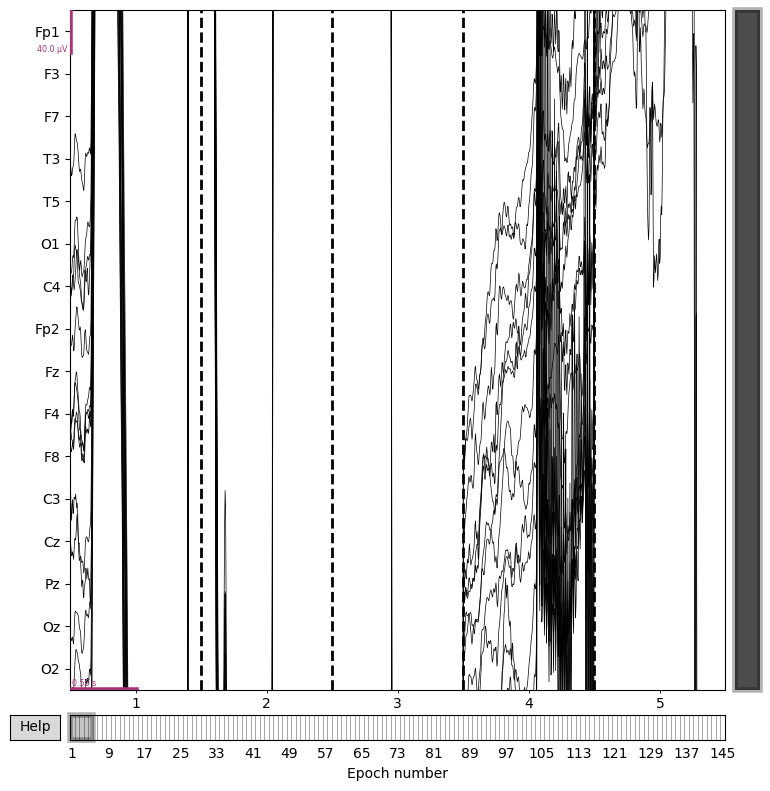

In [50]:
eog_epochs.plot(n_epochs=5)
plt.show()

## Autoreject

In [22]:
raw_autoreject = raw_notch.copy()
raw_autoreject

<RawEDF | Bader_Autism_24_11_2011S001R09.edf, 16 x 212144 (828.6 s), ~25.9 MB, data loaded>

In [23]:
epochs = mne.make_fixed_length_epochs(raw_autoreject, duration=3, preload=True)
epochs

Not setting metadata
276 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 276 events and 768 original time points ...
0 bad epochs dropped


<Epochs | 276 events (all good), 0 – 2.996 s (baseline off), ~25.9 MB, data loaded,
 '1': 276>

No projector specified for this dataset. Please consider the method self.add_proj.


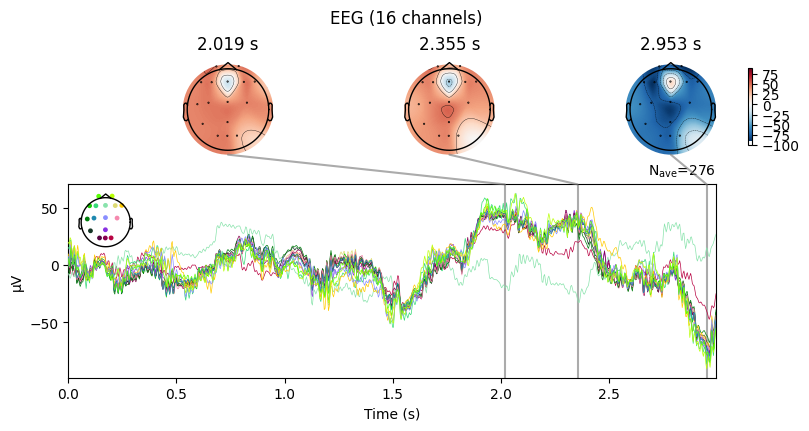

In [24]:
epochs.average().detrend().plot_joint()
plt.show()

In [25]:
ar = AutoReject(n_interpolate=None, random_state=11, n_jobs=1, verbose=True)
epochs_ar, reject_log = ar.fit_transform(epochs, return_log=True)

/home/fahmi/research/eegautism/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/16 [00:00<?,       ?it/s]

100%|██████████| Creating augmented epochs : 16/16 [00:00<00:00,   22.77it/s]
100%|██████████| Computing thresholds ... : 16/16 [00:30<00:00,    1.93s/it]































































































100%|██████████| Repairing epochs : 276/276 [00:01<00:00,  145.57it/s]











































































































































































































































































100%|██████████| Repairing epochs : 276/276 [00:07<00:00,   34.81it/s]






















100%|██████████| Fold : 10/10 [00:01<00:00,    5.07it/s]



















































































































































































100%|██████████| Repairing epochs : 276/276 [00:04<00:00,   61.84it/s]


















Estimated consensus=0.20 and n_interpolate=1







































































































































































































































































100%|██████████| Repairing epochs : 276/276 [00:05<00:00,   46.42it/s]

Dropped 189 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 74, 75, 78, 111, 118, 120, 121, 122, 123, 124, 125, 126, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 143, 146, 150, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 166, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 208, 212, 213, 214, 217, 218, 219, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 245, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275


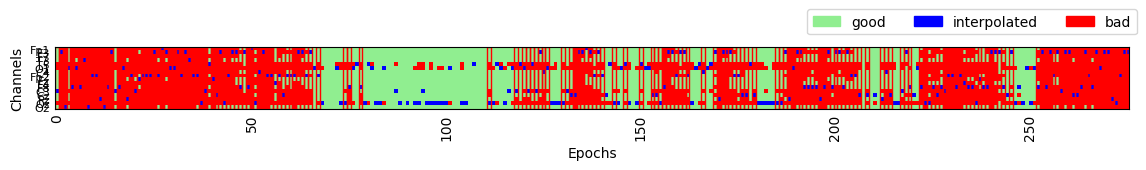

In [26]:
reject_log.plot('horizontal')
plt.show()

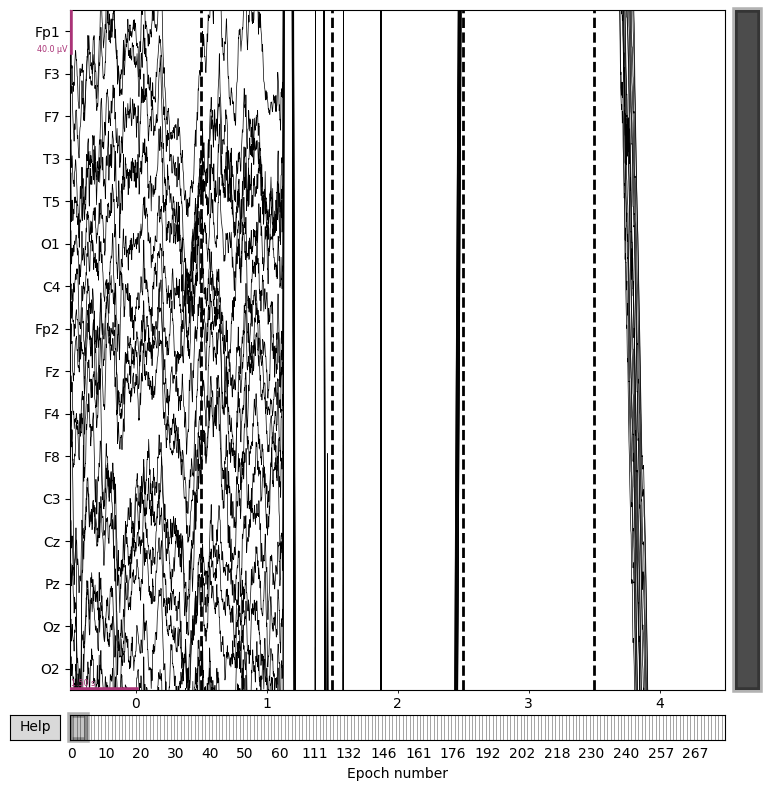

In [27]:
epochs[reject_log.bad_epochs].plot(n_epochs=5)
plt.show()

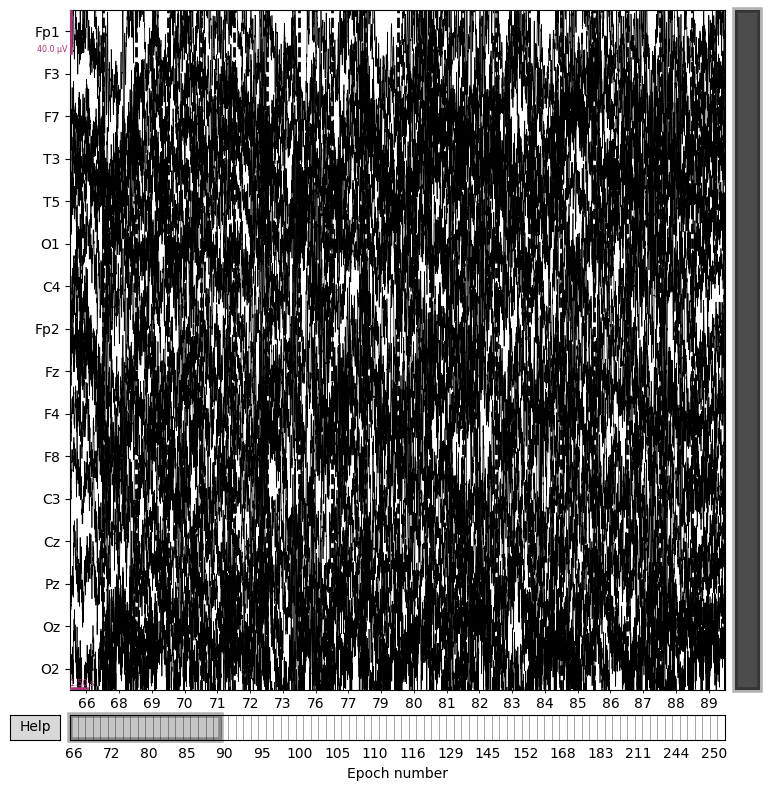

In [28]:
epochs[~reject_log.bad_epochs].plot(n_epochs=20)
plt.show()

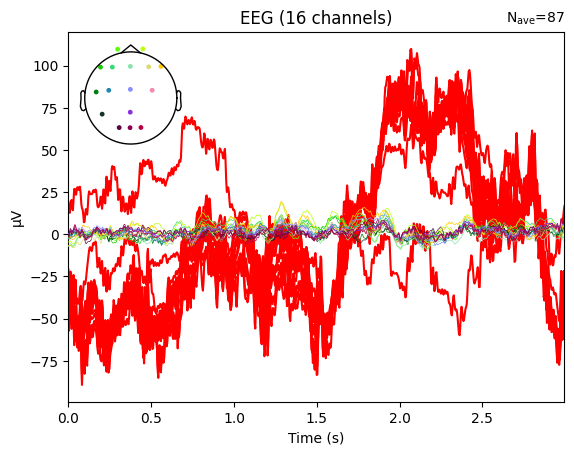

In [29]:
evoked_bad = epochs[reject_log.bad_epochs].average()
plt.figure()
plt.plot(evoked_bad.times, evoked_bad.data.T * 1e6, 'r', zorder=-1)
epochs_ar.average().plot(axes=plt.gca())
plt.show()

In [30]:
ica = mne.preprocessing.ICA(random_state=99)
ica.fit(epochs[~reject_log.bad_epochs])
ica

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 16 components
Fitting ICA took 0.8s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,21 iterations on epochs (66816 samples)
ICA components,16
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


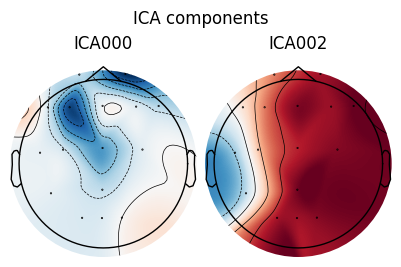

In [31]:
exclude = [0,  # blinks
           2  # saccades
           ]
ica.plot_components(exclude)
ica.exclude = exclude
plt.show()

Applying ICA to Evoked instance
    Transforming to ICA space (16 components)
    Zeroing out 2 ICA components
    Projecting back using 16 PCA components


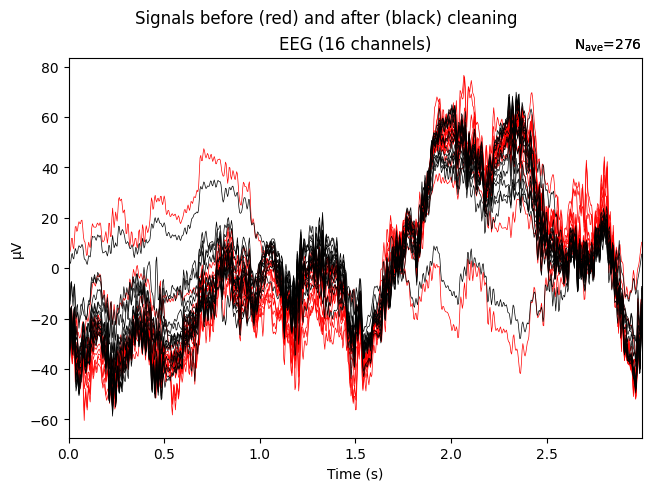

Applying ICA to Epochs instance
    Transforming to ICA space (16 components)
    Zeroing out 2 ICA components
    Projecting back using 16 PCA components


<Epochs | 276 events (all good), 0 – 2.996 s (baseline off), ~25.9 MB, data loaded,
 '1': 276>

In [32]:
ica.plot_overlay(epochs.average(), exclude=ica.exclude)
ica.apply(epochs, exclude=ica.exclude)

In [45]:
X = epochs[~reject_log.bad_epochs].get_data() * 1e6
X

array([[[  5.98168246,   0.10624665,  -3.74354669, ...,  10.67007863,
          12.24088098,  12.70915831],
        [ 53.81909157,  50.14690853,  44.49859648, ...,   1.07542838,
           6.8475428 ,   7.17122038],
        [ 23.3812771 ,  10.43486635,  -2.03910475, ...,   7.05091185,
          10.25908207,  11.13612025],
        ...,
        [ 23.51617288,  20.55708695,  21.40125325, ...,   8.47601331,
          12.32450099,  11.58795763],
        [-16.44058599, -20.28969186, -16.12861818, ...,  15.38539381,
          25.22181931,  26.70636906],
        [  4.93564452,   2.49840218,   7.04602026, ...,  22.40975191,
          33.00494834,  36.30931907]],

       [[ 13.22202792,   5.38250188,   1.41779935, ...,  12.92632929,
          10.93703809,  10.67945467],
        [  9.03965283,   3.5769329 ,   1.59721006, ..., -20.76963011,
         -19.74021919, -13.84630472],
        [  8.90693372,   6.49220212,   4.46175492, ...,  -1.00853038,
          -2.65308771,   3.41797549],
        ...,


In [46]:
X.shape

(87, 16, 768)